In [1]:
import numpy
import matplotlib.pyplot as plt
from pandas import read_csv
import math
from keras.models import Sequential, Model
from keras.layers import Dense, Reshape, Input, Multiply
from keras.layers import LSTM, GRU
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from plot_losses import plot_losses
from dump_model import dump_model

Using TensorFlow backend.


# Prédiction de séquence
Hypothèse : on a détecté une récurrence, éventuellement par autocorrélation : 12 (normal, c'est annuel, 12 mois).

On apprend avec un lookhead de 15 (12 + 3), et on lance à prédiction en l'amorçant avec un échantillon de 15.

On utilise un bête perceptron à la place de LSTM

In [2]:
# convert an array of values into a dataset matrix
def create_dataset(dataset, look_back):
	dataX, dataY = [], []
	for i in range(len(dataset)-look_back-1):
		a = dataset[i:(i+look_back), 0]
		dataX.append(a)
		dataY.append(dataset[i + look_back, 0])
	return numpy.array(dataX), numpy.array(dataY)

In [3]:
# fix random seed for reproducibility
numpy.random.seed(7)
# load the dataset
dataframe = read_csv('https://raw.githubusercontent.com/jbrownlee/Datasets/master/airline-passengers.csv', usecols=[1], engine='python', skipfooter=3)

In [4]:
dataset = dataframe.values
dataset = dataset.astype('float32')
# normalize the dataset
scaler = MinMaxScaler(feature_range=(0, 1))
dataset = scaler.fit_transform(dataset)

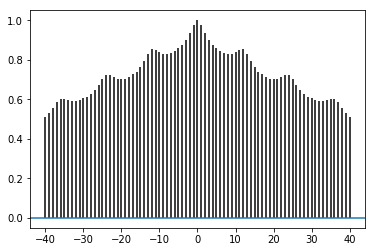

In [5]:
_,acorr,_,_ = plt.acorr( dataset[:,0], maxlags = 40 )

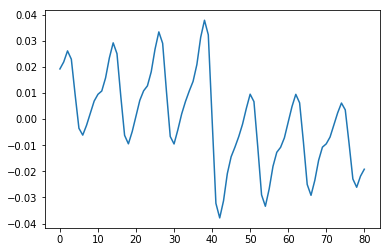

In [6]:
plt.plot(numpy.gradient(acorr))

In [7]:
# split into train and test sets
train_size = int(len(dataset) * 0.67)
test_size = len(dataset) - train_size
train, test = dataset[0:train_size,:], dataset[train_size:len(dataset),:]

In [8]:
# reshape into X=t and Y=t+1
look_back = 15
trainX, trainY = create_dataset(train, look_back)
testX, testY = create_dataset(test, look_back)

In [9]:
# reshape input to be [samples, time steps, features]
trainX = numpy.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
testX = numpy.reshape(testX, (testX.shape[0], 1, testX.shape[1]))

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 1, 15)        0                                            
__________________________________________________________________________________________________
reshape_1 (Reshape)             (None, 15)           0           input_1[0][0]                    
__________________________________________________________________________________________________
alpha (Dense)                   (None, 4)            64          reshape_1[0][0]                  
__________________________________________________________________________________________________
charlie (Dense)                 (None, 4)            64          reshape_1[0][0]                  
__________________________________________________________________________________________________
multiply_1

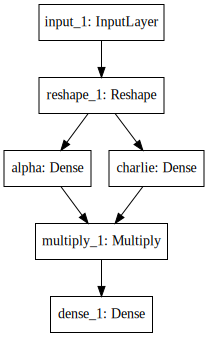

In [10]:
# create and fit the LSTM network
input1 = Input((1, look_back))
input2 = Reshape((look_back,))(input1)
alpha = Dense(4, activation='hard_sigmoid', name='alpha')(input2)
charlie = Dense(4, activation='tanh', name='charlie')(input2)
# model.add(Dense(look_back, input_shape=(1, look_back), activation='hard_sigmoid'))
# model.add(Dense(look_back, activation='tanh'))
# model.add(Dense(1))
# model.add(Reshape((1,)))
rnn0 = Multiply()([alpha, charlie])
output = Dense(1)(rnn0)
model = Model(input1, output)
dump_model(model)

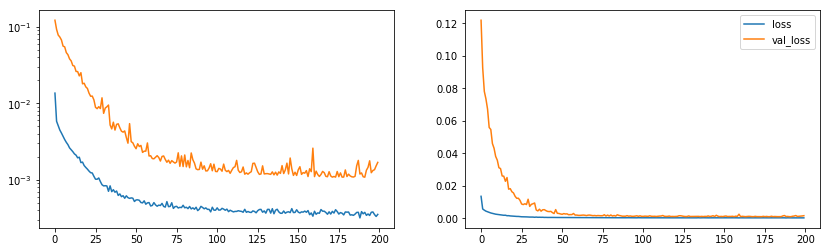

In [11]:
model.compile(loss='mean_squared_error', optimizer='adamax')
model.fit(trainX, trainY, epochs=200, batch_size=1, verbose=2, callbacks=[plot_losses], validation_data=(testX, testY))

In [12]:
# make predictions
trainPredict = model.predict(trainX)
testPredict = model.predict(testX)

In [13]:
# invert predictions
trainPredict = scaler.inverse_transform(trainPredict)
trainY = scaler.inverse_transform([trainY])
testPredict = scaler.inverse_transform(testPredict)
testY = scaler.inverse_transform([testY])

In [14]:
# calculate root mean squared error
trainScore = math.sqrt(mean_squared_error(trainY[0], trainPredict[:,0]))
print('Train Score: %.2f RMSE' % (trainScore))
testScore = math.sqrt(mean_squared_error(testY[0], testPredict[:,0]))
print('Test Score: %.2f RMSE' % (testScore))

Train Score: 10.45 RMSE
Test Score: 21.30 RMSE


In [15]:
# shift train predictions for plotting
trainPredictPlot = numpy.empty_like(dataset)
trainPredictPlot[:, :] = numpy.nan
trainPredictPlot[look_back:len(trainPredict)+look_back, :] = trainPredict

In [16]:
# shift test predictions for plotting
testPredictPlot = numpy.empty_like(dataset)
testPredictPlot[:, :] = numpy.nan
testPredictPlot[len(trainPredict)+(look_back*2)+1:len(dataset)-1, :] = testPredict

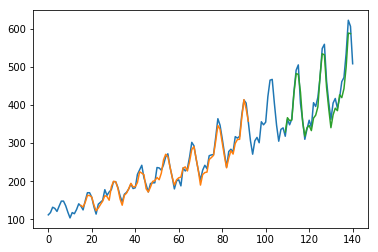

In [17]:
# plot baseline and predictions
plt.plot(scaler.inverse_transform(dataset))
plt.plot(trainPredictPlot)
plt.plot(testPredictPlot)
plt.show()

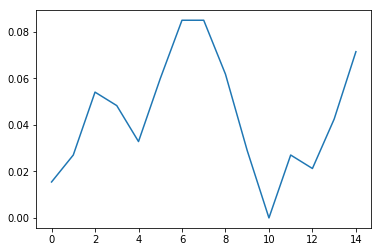

In [18]:
start = trainX[[0]] # Courbe d'amorçage
#start = numpy.random.random((1,1,15))/10 #trainX[[0]] # Courbe d'amorçage
plt.plot(start[0,0])
results = start.tolist()
#print(results[0][0])
#print(start)
results2 = [x for x in results[0][0]]
for _ in range(150):
    r = model.predict(numpy.array(results))
    #print(r)
    results2.append(r[0,0])
    results[0][0].append(r[0,0])
    del results[0][0][0]
    #plt.plot(results[0][0])
    #print(results)

results = numpy.array(results)

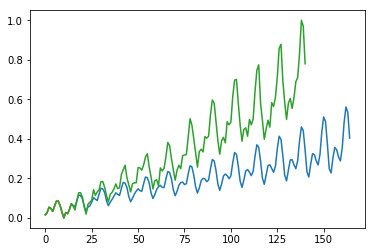

In [19]:
plt.plot(results2)
plt.plot(start[0,0])
plt.plot(dataset)


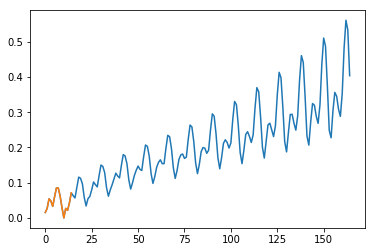

In [20]:
plt.plot(results2)
plt.plot(start[0,0])

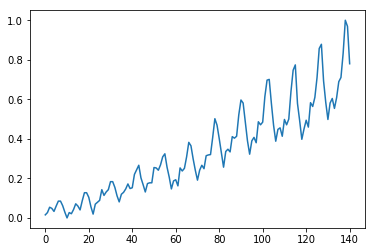

In [21]:
plt.plot(dataset[0:len(results2)])

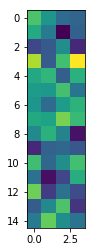

In [37]:
plt.imshow(model.get_layer('alpha').get_weights()[0])

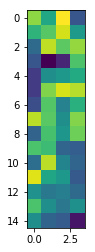

In [38]:
plt.imshow(model.get_layer('charlie').get_weights()[0])

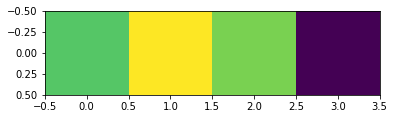

In [43]:
plt.imshow(model.get_layer('alpha').get_weights()[1].reshape(1,4))

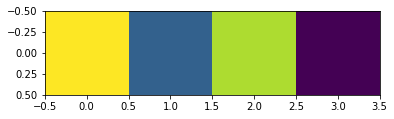

In [42]:
plt.imshow(model.get_layer('charlie').get_weights()[1].reshape(1,4))

In [46]:
(model.get_layer('charlie').get_weights()[0])

array([[ 0.3313779 ,  0.00161053,  0.5760066 , -0.4740457 ],
       [ 0.07470653,  0.20595583,  0.48573756, -0.08577263],
       [-0.3629295 ,  0.44126278,  0.21545693,  0.348153  ],
       [-0.47258022, -0.857181  , -0.70480794,  0.17623757],
       [-0.6013864 , -0.14348687, -0.09262973,  0.01647741],
       [-0.6087599 ,  0.30411863,  0.4892257 ,  0.41912857],
       [-0.51475   ,  0.19070925, -0.21910429,  0.05047194],
       [ 0.430378  ,  0.21097901, -0.14558245,  0.30794847],
       [-0.40327698,  0.1613065 , -0.10513051,  0.26195246],
       [ 0.16844136,  0.12789033, -0.3882988 , -0.43136463],
       [-0.33802846,  0.42553225, -0.21294995, -0.38698536],
       [ 0.50828373, -0.01538835, -0.09404115, -0.4521084 ],
       [-0.13321438, -0.2826182 , -0.24328475, -0.36418006],
       [ 0.17196786, -0.14479537, -0.28901666, -0.13794604],
       [-0.14261387, -0.39582396, -0.44003892, -0.7786872 ]],
      dtype=float32)

In [47]:

(model.get_layer('alpha').get_weights()[0])

array([[ 0.42744267,  0.18185124, -0.0498146 , -0.07694521],
       [ 0.2873187 ,  0.02756876, -0.49601138, -0.10008674],
       [-0.22433263, -0.13392021,  0.13751617, -0.34775624],
       [ 0.62829936, -0.1275949 ,  0.39966366,  0.7857522 ],
       [ 0.27921754,  0.34937912, -0.10984537,  0.32177782],
       [ 0.21433184,  0.18834288,  0.4097634 ,  0.00130702],
       [ 0.17961752, -0.04706796,  0.20786598,  0.33306438],
       [ 0.28051883,  0.24575123,  0.53014624,  0.3654105 ],
       [ 0.11746725,  0.32707405,  0.07510956, -0.43221137],
       [-0.35507756, -0.09258947, -0.07250212, -0.14733492],
       [ 0.3948871 , -0.06226506,  0.13702904,  0.4036297 ],
       [-0.01098847, -0.44514254, -0.22478482,  0.30027765],
       [ 0.5025534 , -0.2672715 , -0.01726304, -0.19324455],
       [-0.12181183,  0.10754   ,  0.42997158, -0.29761672],
       [ 0.03760144,  0.4843681 ,  0.13679673, -0.00635071]],
      dtype=float32)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_10 (LSTM)               (None, None, 50)          20200     
_________________________________________________________________
dropout_9 (Dropout)          (None, None, 50)          0         
_________________________________________________________________
lstm_11 (LSTM)               (None, 100)               60400     
_________________________________________________________________
dropout_10 (Dropout)         (None, 100)               0         
_________________________________________________________________
dense_6 (Dense)              (None, 1)                 101       
Total params: 80,701
Trainable params: 80,701
Non-trainable params: 0
_________________________________________________________________


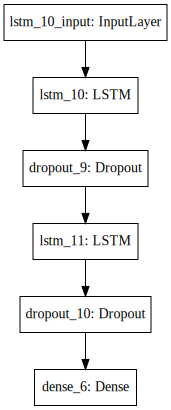

In [53]:
from keras.layers import Dropout

# build the model
model = Sequential()
# layer 1: LSTM
model.add(LSTM(50, input_shape=(None, 50), return_sequences=True))
model.add(Dropout(0.2))
# layer 2: LSTM
model.add(LSTM(100, return_sequences=False))
model.add(Dropout(0.2))
# layer 3: dense
# linear activation: a(x) = x
model.add(Dense(1, activation='linear'))
# compile the model
model.compile(loss="mse", optimizer="rmsprop")

dump_model(model)